In [16]:
import numpy as np
import tensorflow as tf
import os
import cv2
%matplotlib inline 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import optimizers

In [51]:
# Constants
DATASET_PATH = "dataset"
IMAGE_SIZE = (128,128)
BATCH_SIZE = 32
CLASS_NAMES = ["fire", "nonfire"]
EPOCHS=5

In [73]:
# Load the data
image_gen = ImageDataGenerator(rescale=1./255, validation_split=0.3, 
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_images = image_gen.flow_from_directory(
    directory=DATASET_PATH,
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    batch_size=BATCH_SIZE,
    color_mode="rgba",
    subset="training"
)

validation_images = image_gen.flow_from_directory(
    directory=DATASET_PATH,
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    batch_size=BATCH_SIZE,
    color_mode="rgba",
    subset="validation"
)

Found 1836 images belonging to 2 classes.
Found 785 images belonging to 2 classes.


/home/martin/.local/share/virtualenvs/d7041e-mini-project-qo9XQE3w/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


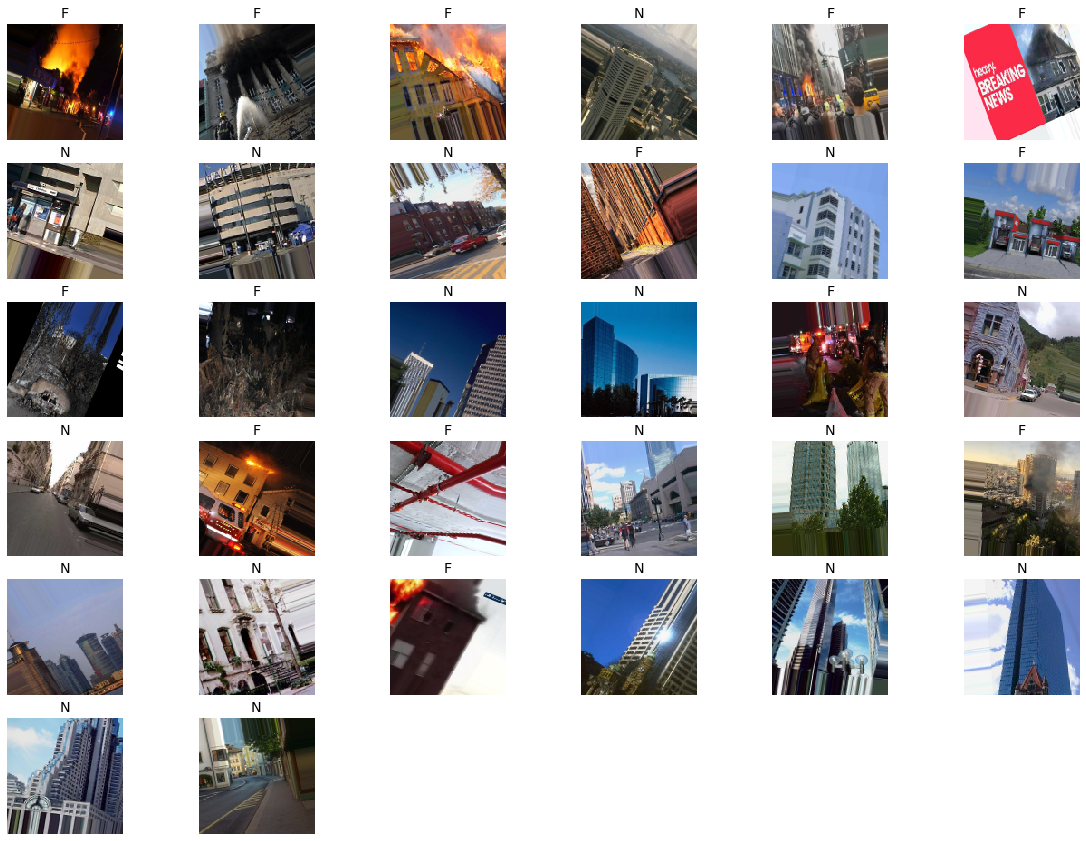

In [65]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8, 6,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
# Display the first batch        
image_batch, label_batch = next(train_images)
show_batch(image_batch, label_batch)

In [20]:
print(f'Loaded {BATCH_SIZE * (len(train_images) - 1) + len(train_images[len(train_images) - 1][0])} images')
print(f'Created {len(train_images)} batches')

Loaded 1836 images
Created 58 batches


In [74]:
class CNN:
    def __init__(self):
        self.model = Sequential()
        self.input_shape = IMAGE_SIZE + (3,)
        chanDim = -1
        
        #CONV => RELU => POOL
        self.model.add(SeparableConv2D(32, (3, 3), padding="same"))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization(axis=chanDim))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # (CONV => RELU) * 2 => POOL
        self.model.add(SeparableConv2D(64, (3, 3), padding="same"))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization(axis=chanDim))
        self.model.add(SeparableConv2D(64, (3, 3), padding="same"))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization(axis=chanDim))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of FC => RELU layers
        self.model.add(Flatten())
        self.model.add(Dense(128))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        # second set of FC => RELU layers
        self.model.add(Dense(128))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        self.model.add(Dense(1, activation="sigmoid"))
        
        opt = optimizers.SGD(lr=0.01, momentum=0.9,
            decay=0.01 / EPOCHS)
        
        self.model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [71]:
cnn = CNN()

H = cnn.model.fit_generator(
    train_images,
    steps_per_epoch=train_images.samples // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data = validation_images, 
    validation_steps = validation_images.samples // BATCH_SIZE
)

  ...
    to  
  ['...']
Train for 57 steps, validate for 24 steps
Epoch 1/5
57/57 [==============================] - 68s 1s/step - loss: 0.8346 - accuracy: 0.6153 - val_loss: 0.7023 - val_accuracy: 0.4154
Epoch 2/5
57/57 [==============================] - 70s 1s/step - loss: 0.6392 - accuracy: 0.6552 - val_loss: 0.6848 - val_accuracy: 0.5404
Epoch 3/5
57/57 [==============================] - 70s 1s/step - loss: 0.6190 - accuracy: 0.6785 - val_loss: 0.6824 - val_accuracy: 0.5508
Epoch 4/5
57/57 [==============================] - 70s 1s/step - loss: 0.5766 - accuracy: 0.6984 - val_loss: 0.6764 - val_accuracy: 0.5417
Epoch 5/5
57/57 [==============================] - 69s 1s/step - loss: 0.5616 - accuracy: 0.7167 - val_loss: 0.5968 - val_accuracy: 0.6081


{'loss': [0.8328009909906832, 0.6391232749839579, 0.6167110732019344, 0.5756232314257823, 0.5598677325407312], 'accuracy': [0.61529934, 0.6552106, 0.67849225, 0.6984479, 0.71674055], 'val_loss': [0.7023413802186648, 0.6848151162266731, 0.6823930541674296, 0.6764496713876724, 0.5968396117289861], 'val_accuracy': [0.4153646, 0.54036456, 0.55078125, 0.5416667, 0.60807294]}


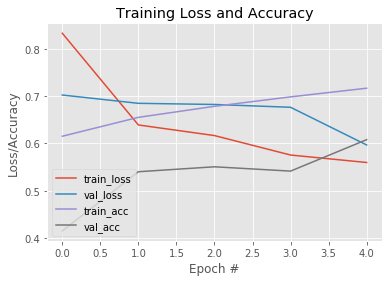

In [75]:
print(H.history)
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(config.TRAINING_PLOT_PATH)